In [139]:
import math
import random
import numpy as np
from scipy.integrate import quad

def multivariate_t_dist_pdf(x,cov,v):
    cov_matrix = np.array(cov, dtype='float')
    x_matrix = np.array(x, dtype='float')
    
    d = len(x_matrix)
    
    first_term = 1 / math.sqrt(np.linalg.det(cov_matrix))
    second_term = 1 / math.sqrt((v*math.pi)**d)
    third_term = math.gamma((v+d)/2) / math.gamma(v/2)
    fourth_term = (1+np.matmul(np.matmul(x_matrix,np.linalg.inv(cov_matrix)),(x_matrix).transpose())/v)**(-(v+d)/2)
    
    return(first_term*second_term*third_term*fourth_term)

def multivariate_t_dist_cdf(x1,x2,c,df):
    def quadFunc(x):
        return multivariate_t_dist_pdf([x1,x],c,df)
    res, error = quad(quadFunc,-10,x2,epsabs=1.49e-04)
    return res

def mvt_t_cdf_inverse(x_1,a,co,dof_f):
    x_2 = np.linspace(-10,10,200)
    new = -10
    small = 10
    for i in x_2:
        dif = a - multivariate_t_dist_cdf(x_1,i,co,dof_f)
        if abs(dif) < small:
            small = abs(dif) 
            new = i     
    return new

In [88]:
from scipy.stats import t

data_source = con.get_returns([84703, 84705])
Fund1 = data_source.iloc[:,0]
Fund2 = data_source.iloc[:,1]
# sns.jointplot(Fund1,Fund2,kind='scatter');

mean = (stat(Fund1,Fund2)['Mean1']+stat(Fund1,Fund2)['Mean2'])/2
std = (stat(Fund1,Fund2)['Std1']+stat(Fund1,Fund2)['Std2'])/2
var1 = stat(Fund1,Fund2)['Std1']**2
var2 = stat(Fund1,Fund2)['Std2']**2
covar = stat(Fund1,Fund2)['Covariance']
df = 4

def RandomPoint(x):
    x_var_1 = t.ppf(x,df)
    a =  multivariate_t_dist_cdf(x_var_1,10,[[var1,covar],[covar,var2]],df)
    
    r2 = a*random.random()
    x_var_2 = mvt_t_cdf_inverse(x_var_1,r2,[[var1,covar],[covar,var2]],df)
        
    return(x_var_1,x_var_2)


 95% Var is -22.0%
The equivalent cVar is -22.070999999999998%
95% Var is -16.7%
The equivalent cVar is -16.874%
95% Var is -11.7%
The equivalent cVar is -12.046%


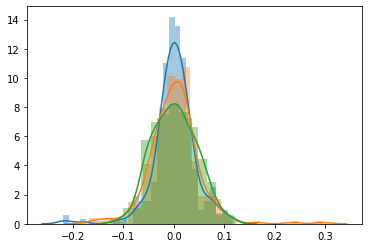

In [141]:
import seaborn as sns 
from scipy import stats

numbers = [random.random() for i in range(300)]
%prun result = list(map(RandomPoint,numbers))
uniform = t.cdf(result,df)
adj_normal = stats.t(loc=mean,scale=0.85*std,df=df)
fund1_simul = adj_normal.ppf(uniform[:,0])
fund2_simul = adj_normal.ppf(uniform[:,1])

covariance_matrix = [[var1,covar],[covar,var2]] 
mvnorm = stats.multivariate_normal(mean=[stat(Fund1,Fund2)['Mean1'],stat(Fund1,Fund2)['Mean2']],cov=covariance_matrix)
x = mvnorm.rvs(300)

weights = [0.5,0.5]
P_returns = np.array([weights[0]*Fund1[i]+weights[1]*Fund2[i] for i in range(len(Fund1))])
sns.distplot(P_returns);
print('95% Var is '+str(round((np.percentile(P_returns,0.05))*100,1))+'%')
c_var = [round(i,5) for i in P_returns if i<=np.percentile(P_returns,0.05)]
print('The equivalent cVar is '+str(sum(c_var)/len(c_var)*100)+'%')

P_returns_simul = np.array([weights[0]*fund1_simul[i]+weights[1]*fund2_simul[i] for i in range(len(fund1_simul))])
sns.distplot(P_returns_simul);
print('95% Var is '+str(round((np.percentile(P_returns_simul,0.05))*100,1))+'%')
c_var = [round(i,5) for i in P_returns_simul if i<=np.percentile(P_returns_simul,0.05)]
print('The equivalent cVar is '+str(sum(c_var)/len(c_var)*100)+'%')

P_simul_nocor = [weights[0]*x[i,0]+weights[1]*x[i,1] for i in range(len(x))]
sns.distplot(P_simul_nocor)
print('95% Var is '+str(round((np.percentile(P_simul_nocor,0.05))*100,1))+'%')
c_var = [round(i,5) for i in P_simul_nocor if i<=np.percentile(P_simul_nocor,0.05)]
print('The equivalent cVar is '+str(sum(c_var)/len(c_var)*100)+'%')

In [3]:
from antarctica.connector import Antarctica
con = Antarctica()

In [4]:
def stat(x,y):
    s1 = 0.0
    for item in x:
        s1 = s1 + item
    mean1 = s1 / len(x)
    
    s2 = 0.0
    for thing in y:
        s2 = s2 + thing
    mean2 = s2 / len(y)
    
    std_sum1 = 0.0
    for i in x:
        std_sum1 = std_sum1 + (i-mean1)**2 
    std1 = (std_sum1 / (len(x)-1))**0.5
    
    std_sum2 = 0.0
    for j in y:
        std_sum2 = std_sum2 + (j-mean2)**2
    std2 = (std_sum2 / (len(y)-1))**0.5
    
    cov_sum = 0.0
    for index in range(len(x)):
        cov_sum = cov_sum + (x[index]-mean1)*(y[index]-mean2)
    covariance = cov_sum/(len(x)-1)
    
    correlation = covariance / ((std1)*(std2))
    
    return {'Mean1':mean1,'Mean2':mean2,'Std1':std1,'Std2':std2,'Covariance':covariance,'Correlation':correlation}

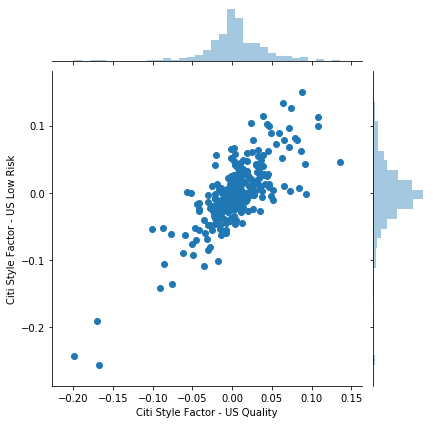

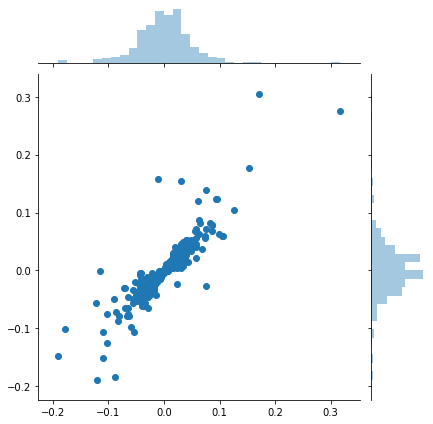

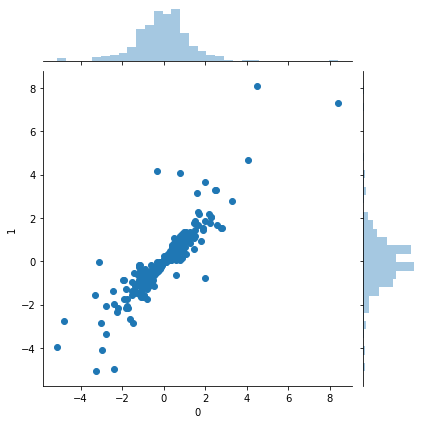

In [146]:
import pandas as pd 

result = pd.DataFrame(result)
sns.jointplot(Fund1,Fund2);
sns.jointplot(fund1_simul,fund2_simul);
sns.jointplot(result.iloc[:,0],result.iloc[:,1]);